# 의료용 마스크 탐지 모델 구축 : RetinaNet

## Data Set Class 정의

파이토치 모델을 학습시키기 위해선 데이터셋 클래스를 정의해야 함.  
torchvision에서 제공하는 객체 탐지 모델을 학습시키기 위한 데이터셋 클래스의 ______getitem__ 메서드는 이미지 파일과 바운딩 박스 좌표를 반환

In [2]:
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from bs4 import BeautifulSoup
from PIL import Image
import cv2
import numpy as np
import time
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms
from matplotlib import pyplot as plt
import os

In [3]:
def generate_box(obj):
    
    xmin = float(obj.find('xmin').text)
    ymin = float(obj.find('ymin').text)
    xmax = float(obj.find('xmax').text)
    ymax = float(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

In [4]:
def generate_label(obj):

    if obj.find('name').text == "with_mask":

        return 1

    elif obj.find('name').text == "mask_weared_incorrect":

        return 2

    return 0

In [5]:
def generate_target(file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, "html.parser")
        objects = soup.find_all("object")

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))

        boxes = torch.as_tensor(boxes, dtype=torch.float32) 
        labels = torch.as_tensor(labels, dtype=torch.int64) 
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        return target

In [6]:
def plot_image_from_output(img, annotation):
    
    img = img.cpu().permute(1,2,0)
    
    rects = []

    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 0 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        
        elif annotation['labels'][idx] == 1 :
            
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
            
        else :
        
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        rects.append(rect)

    return img, rects

In [7]:
class MaskDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))
        self.transform = transform
        
    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)
        
        if 'test' in self.path:
            label_path = os.path.join("test_annotations/", file_label)
        else:
            label_path = os.path.join("annotations/", file_label)

        img = Image.open(img_path).convert("RGB")
        target = generate_target(label_path)
        
        to_tensor = torchvision.transforms.ToTensor()

        if self.transform:
            img, transform_target = self.transform(np.array(img), np.array(target['boxes']))
            target['boxes'] = torch.as_tensor(transform_target)

        # tensor로 변경
        img = to_tensor(img)


        return img, target

In [8]:
def collate_fn(batch):
    return tuple(zip(*batch))

dataset = MaskDataset('images/')
test_dataset = MaskDataset('test_images/')


# 훈련용 데이터와 시험용 데이터를 batch 단위로 불러올 수 있게 torch.utils.data.DataLoader 함수를 활용해 data_loader와 test_data_loader를 각각 정의

data_loader = torch.utils.data.DataLoader(dataset, batch_size=4, collate_fn=collate_fn)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2, collate_fn=collate_fn)

## 모델 불러오기

torchvision에서는 각종 컴퓨터 비전 문제를 해결하기 위한 딥러닝 모델을 쉽게 불러올 수 있는 API를 제공.  
torchvision.models 모듈을 활용하여 RetinaNet 모델을 불러온다.   
RetinaNet은 torchvision 0.8.0 이상에서 제공

In [14]:
 !pip install --upgrade pip

Looking in indexes: http://ftp.daumkakao.com/pypi/simple
     |████████████████████████████████| 1.5 MB 10.9 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 21.0.1
    Uninstalling pip-21.0.1:
      Successfully uninstalled pip-21.0.1


In [32]:
!pip install torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in indexes: http://ftp.daumkakao.com/pypi/simple
Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [9]:
import torchvision
import torch

torchvision.__version__

'0.8.1+cu101'

In [12]:
retina = torchvision.models.detection.retinanet_resnet50_fpn(num_classes = 3, pretrained=False, pretrained_backbone = True)

## 전이 학습

In [13]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_epochs = 10
retina.to(device)
    
# parameters
params = [p for p in retina.parameters() if p.requires_grad] # gradient calculation이 필요한 params만 추출
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

len_dataloader = len(data_loader)

for epoch in range(num_epochs):
    start = time.time()
    retina.train()

    i = 0    
    epoch_loss = 0
    for images, targets in data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = retina(images, targets) 

        losses = sum(loss for loss in loss_dict.values()) 

        i += 1

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        epoch_loss += losses 
    print(epoch_loss, f'time: {time.time() - start}')

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


tensor(286.5137, device='cuda:0', grad_fn=<AddBackward0>) time: 72.6428325176239
tensor(268.6891, device='cuda:0', grad_fn=<AddBackward0>) time: 72.66669535636902
tensor(252.1103, device='cuda:0', grad_fn=<AddBackward0>) time: 73.57604622840881
tensor(223.9336, device='cuda:0', grad_fn=<AddBackward0>) time: 72.71871304512024
tensor(174.0220, device='cuda:0', grad_fn=<AddBackward0>) time: 154.69243955612183
tensor(118.5655, device='cuda:0', grad_fn=<AddBackward0>) time: 154.53786635398865
tensor(96.3432, device='cuda:0', grad_fn=<AddBackward0>) time: 155.21777653694153
tensor(83.8304, device='cuda:0', grad_fn=<AddBackward0>) time: 155.10083866119385
tensor(77.6173, device='cuda:0', grad_fn=<AddBackward0>) time: 155.05730652809143
tensor(72.3588, device='cuda:0', grad_fn=<AddBackward0>) time: 154.72100830078125


In [16]:
# 학습된 가중치 저장

torch.save(retina.state_dict(),f'retina_{num_epochs}.pt')
retina.load_state_dict(torch.load(f'retina_{num_epochs}.pt'))

<All keys matched successfully>

In [17]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
retina.to(device)

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256)
          )
        )
        (1): Bottleneck

## 예측

make_prediction 함수에는 학습된 딥러닝 모델을 활용해 예측하는 알고리즘이 저장돼 있다.   
threshold 파라미터를 조정해 신뢰도가 일정 수준 이상의 바운딩 박스만 선택. 보통 0.5 이상인 값을 최종 선택.

In [18]:
def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold : #threshold 넘는 idx 구함
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]


    return preds

In [19]:
from tqdm import tqdm

labels = []
preds_adj_all = []
annot_all = []

for im, annot in tqdm(test_data_loader, position = 0, leave = True):
    im = list(img.to(device) for img in im)
    #annot = [{k: v.to(device) for k, v in t.items()} for t in annot]

    for t in annot:
        labels += t['labels']

    with torch.no_grad():
        preds_adj = make_prediction(retina, im, 0.5)
        preds_adj = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj]
        preds_adj_all.append(preds_adj)
        annot_all.append(annot)

100%|██████████| 85/85 [00:44<00:00,  1.90it/s]


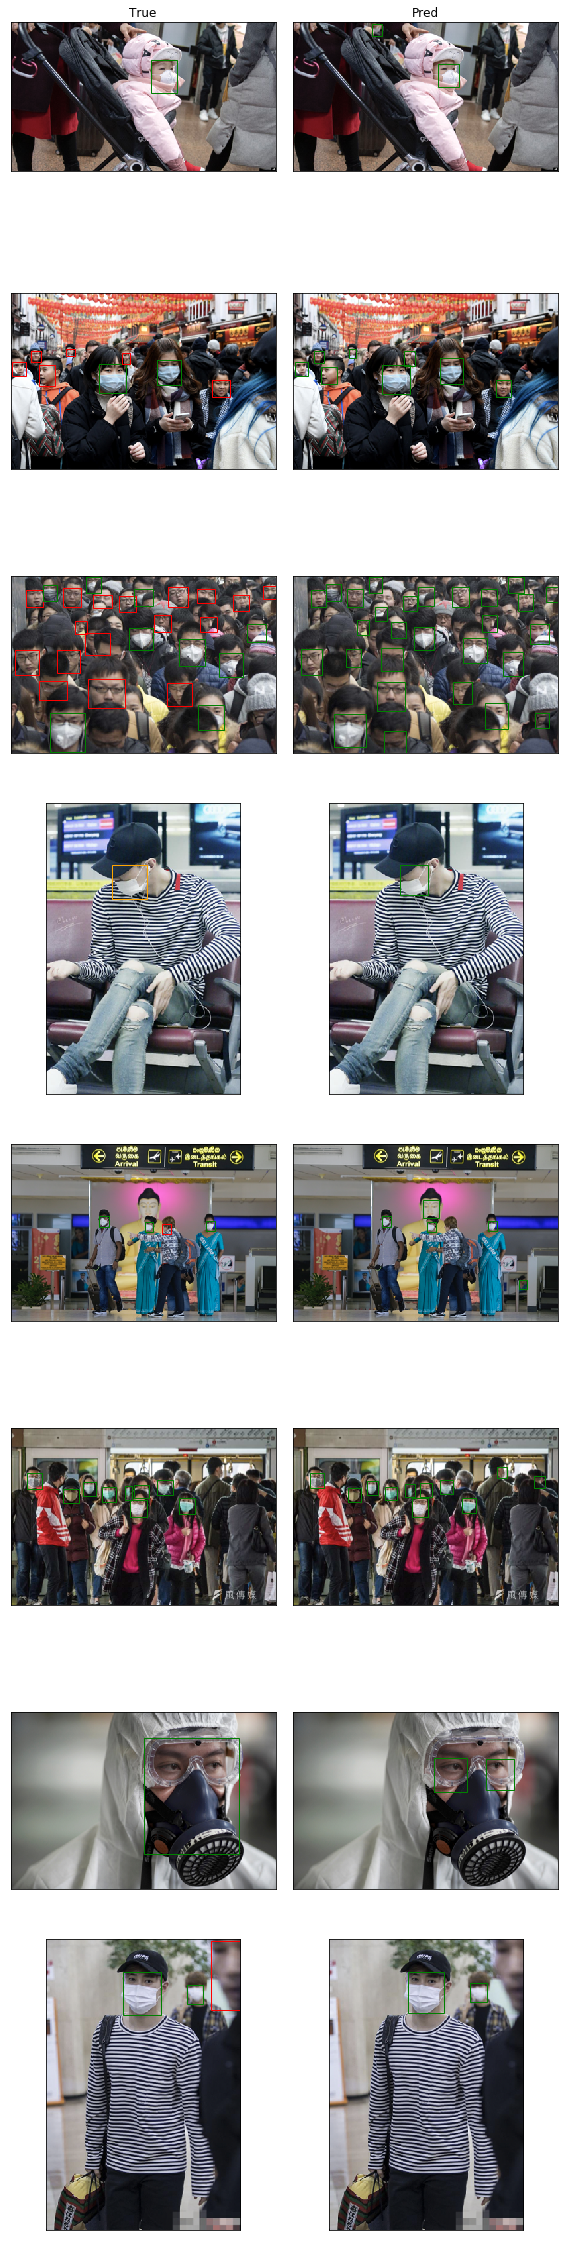

In [20]:
# 실제 바운딩 박스와 예측한 바운딩 박스에 대한 시각화를 진행

nrows = 8
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4, nrows*4))

batch_i = 0
for im, annot in test_data_loader:
    pos = batch_i * 4 + 1
    for sample_i in range(len(im)) :
        
        img, rects = plot_image_from_output(im[sample_i], annot[sample_i])
        axes[(pos)//2, 1-((pos)%2)].imshow(img)
        for rect in rects:
            axes[(pos)//2, 1-((pos)%2)].add_patch(rect)
        
        img, rects = plot_image_from_output(im[sample_i], preds_adj_all[batch_i][sample_i])
        axes[(pos)//2, 1-((pos+1)%2)].imshow(img)
        for rect in rects:
            axes[(pos)//2, 1-((pos+1)%2)].add_patch(rect)

        pos += 2

    batch_i += 1
    if batch_i == 4:
        break

# xtick, ytick 제거
for idx, ax in enumerate(axes.flat):
    ax.set_xticks([])
    ax.set_yticks([])

colnames = ['True', 'Pred']

for idx, ax in enumerate(axes[0]):
    ax.set_title(colnames[idx])

plt.tight_layout()
plt.show()

왼쪽 열이 실제 바운딩 박스의 라벨과 위치, 오른쪽 열이 모델의 예측 값.  

전반적인 모델 성능을 평가하기 위해 mean Average Precision (mAP)를 산출. mAP는 객체 탐지 모델을 평가할 때 사용하는 지표

In [21]:
%cd Tutorial-Book-Utils/
import utils_ObjectDetection as utils

/home/ubuntu/CUAI_2021/HayunLEE/Tutorial-Book-Utils


In [22]:
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5) 

In [24]:
true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # 배치가 전부 합쳐짐
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')

mAP : 0.37396724805612297
AP : tensor([0.0000, 1.1219, 0.0000], dtype=torch.float64)


0번 클래스인 마스크를 미착용한 객체에 대해서는 0.7684 AP  
1번 클래스인 마스크 착용 객체에 대해서는 0.9188 AP  
2번 클래스인 마스크를 올바르게 착용하지 않은 객체에 대해서는 0.06 AP